In [17]:
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import inspect
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [2]:
yf.pdr_override()

# Define parameters
ticker = 'AAPL'  # Example ticker symbol for Apple Inc.
start_date = '2020-01-01'
end_date = '2024-01-01'
sequence_length = 32  # Length of each sequence

# Fetch data
data = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
data['Adj Close Percent Change'] = data['Adj Close'].pct_change()
data = data[1:] # Remove the NAN row for pct_change
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Adj Close Percent Change
Date,,,,,,,
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349129,146322800,-0.009722
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925629,118387200,0.007968
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582672,108872000,-0.004703
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750244,132079200,0.016086
2020-01-09,76.809998,77.607498,76.550003,77.407501,75.316765,170108400,0.021241
...,...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800,-0.005547
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300,-0.002841
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.903839,48087700,0.000518


In [3]:
# Preprocess data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data)

In [4]:
# Check the mean and standard deviation of each feature
mean_values = np.mean(scaled_features, axis=0)
std_dev_values = np.std(scaled_features, axis=0)

# Print the mean and standard deviation for each feature
for i, (mean, std_dev) in enumerate(zip(mean_values, std_dev_values)):
    print(f"Feature {i+1}: Mean={mean}, Std Dev={std_dev}")

Feature 1: Mean=2.828030789094926e-16, Std Dev=1.0000000000000002
Feature 2: Mean=2.2624246312759407e-16, Std Dev=0.9999999999999999
Feature 3: Mean=-4.5248492625518815e-16, Std Dev=1.0
Feature 4: Mean=1.1312123156379704e-16, Std Dev=0.9999999999999998
Feature 5: Mean=-3.3936369469139114e-16, Std Dev=1.0
Feature 6: Mean=0.0, Std Dev=1.0
Feature 7: Mean=1.0605115459105973e-17, Std Dev=1.0


In [5]:
sequences = []
labels_first = []
labels_last = []

for i in range(len(scaled_features) - sequence_length):
    sequences.append(scaled_features[i:i+sequence_length])
    labels_first.append(scaled_features[i][-1])  # First element of the sequence
    labels_last.append(scaled_features[i+sequence_length-1][-1])  # Last element of the sequence

In [6]:
print(labels_first)

[-0.5161358977776428, 0.320870882889627, -0.2786505376056519, 0.7049558517825196, 0.9488493705193475, 0.05081453065255655, 0.9546960996272444, -0.6950348064524202, -0.2589012066937638, 0.536534573191746, 0.46766598210523297, -0.3767728736134312, 0.11273363053420685, 0.1717261515800759, -0.19250476600504302, -1.4474203520240125, 1.2823408387780533, 0.9342531896636389, -0.12470376459816143, -2.1539697709971874, -0.18609990793984382, 1.5058796417547355, 0.3296680388766735, 0.4972766669675079, -0.6992657451809153, 0.16858324500372626, -0.3416007244054085, 1.0674613586852313, -0.3930670970578608, -0.044493174129649794, -0.9224759283974521, 0.6290962843790796, -0.5415388744350825, -1.1270896438263407, -2.3035748078153473, -1.6587669359793547, 0.6944263075509748, -3.1489624264748635, -0.08382705509453695, 4.348827260517552, -1.5588085266565626, 2.1384962042118163, -1.590860081333367, -0.6844640361369263, -3.7983028096182894, 3.3514833527532777, -1.6993685692392713, -4.728628536919942, 5.61247

In [7]:
print(labels_last)

[0.6290962843790796, -0.5415388744350825, -1.1270896438263407, -2.3035748078153473, -1.6587669359793547, 0.6944263075509748, -3.1489624264748635, -0.08382705509453695, 4.348827260517552, -1.5588085266565626, 2.1384962042118163, -1.590860081333367, -0.6844640361369263, -3.7983028096182894, 3.3514833527532777, -1.6993685692392713, -4.728628536919942, 5.612471380108817, -6.142939720201519, 2.0242475099748245, -1.214382599924242, -0.41866482024265084, -3.0598989640484624, -1.0612780846894665, 4.690655252833112, -0.31678958359499393, 2.433668548391256, -2.0150532241799377, 1.2941012925194941, -0.15269082690861682, -2.5456651882559163, 0.7333670107562461, -0.7361096339469796, 4.071419078394288, -0.6041574894143694, 1.1548611702398788, 0.28527455071895585, 0.8725162900427954, 2.3333655975856145, -0.48799347621259015, 0.3198048100405975, -0.698123068402158, -1.0382231405500189, -1.5186273469894482, 1.306660737260436, -0.23950891212541559, 1.309801325615706, -0.022704025469005854, -0.8230795663

In [8]:
# Convert to tensors
X_train, X_test, y_train_first, y_test_first, y_train_last, y_test_last = train_test_split(sequences, labels_first, labels_last, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_first_tensor = torch.FloatTensor(y_train_first)
y_train_last_tensor = torch.FloatTensor(y_train_last)

X_test_tensor = torch.FloatTensor(X_test)
y_test_first_tensor = torch.FloatTensor(y_test_first)
y_test_last_tensor = torch.FloatTensor(y_test_last)

# Create DataLoaders
batch_size = 5

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_first_tensor, y_train_last_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_first_tensor, y_test_last_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<ipython-input-8-47ecdff36292>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  X_train_tensor = torch.FloatTensor(X_train)


In [9]:
# Example usage of DataLoader for training set
for sequences, first_labels, last_labels in train_loader:
    print("Batch Sequences:")
    print(sequences)
    print("Batch First Labels:")
    print(first_labels)
    print("Batch Last Labels:")
    print(last_labels)
    break  # Print only the first batch for demonstration



Batch Sequences:
tensor([[[ 0.0989,  0.1520,  0.1335,  ...,  0.1223,  0.0351,  0.3171],
         [ 0.2213,  0.2153,  0.2558,  ...,  0.2251,  0.5173,  1.0842],
         [ 0.2556,  0.2281,  0.2380,  ...,  0.2055,  0.1453, -0.2687],
         ...,
         [ 0.2277,  0.2338,  0.2622,  ...,  0.2481, -0.7131,  0.4292],
         [ 0.2620,  0.2539,  0.3002,  ...,  0.2455, -0.9251, -0.0846],
         [ 0.2728,  0.2377,  0.2594,  ...,  0.2085, -0.7341, -0.4546]],

        [[ 0.1188,  0.1247,  0.1622,  ...,  0.1223, -0.7763,  0.1593],
         [ 0.1094,  0.1181,  0.1480,  ...,  0.1287, -0.5236,  0.0153],
         [ 0.1690,  0.1367,  0.1824,  ...,  0.1187, -0.6626, -0.1664],
         ...,
         [ 0.4436,  0.4113,  0.4452,  ...,  0.3761, -0.7651, -0.3734],
         [ 0.4289,  0.3924,  0.2866,  ...,  0.2264,  0.7719, -1.6223],
         [ 0.2974,  0.2707,  0.2881,  ...,  0.2434,  0.0641,  0.1281]],

        [[ 1.6640,  1.6216,  1.6926,  ...,  1.6787, -1.1049,  0.0937],
         [ 1.6694,  1.6288, 

In [10]:
class BiRNN(nn.Module):

    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes."""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

    def __init__(self, num_inputs, num_hiddens, num_layers=1, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.num_inputs = int(num_inputs)
        self.num_hiddens = int(num_hiddens)
        self.f_rnn = nn.LSTM(num_inputs, num_hiddens, num_layers=num_layers)
        self.b_rnn = nn.LSTM(num_inputs, num_hiddens, num_layers=num_layers)
        self.num_hiddens *= 2  # The output dimension will be doubled

        # Additional LSTM layers
        self.f_rnn_2 = nn.LSTM(self.num_hiddens, self.num_hiddens, num_layers=num_layers, batch_first=True)
        self.b_rnn_2 = nn.LSTM(self.num_hiddens, self.num_hiddens, num_layers=num_layers, batch_first=True)

        # Final linear layer
        self.linear = nn.Linear(self.num_hiddens, 1)

    def forward(self, inputs, Hs=None):
      f_H, b_H = Hs if Hs is not None else (None, None)
      f_outputs, f_H = self.f_rnn(inputs, f_H)
      b_outputs, b_H = self.b_rnn(reversed(inputs), b_H)
      outputs = torch.cat((f_outputs, reversed(b_outputs)), dim=2)

      # Additional LSTM layers
      outputs, _ = self.f_rnn_2(outputs)
      outputs, _ = self.b_rnn_2(outputs)

      # Apply linear layer
      outputs = self.linear(outputs)

      return outputs[:, [0, -1], :], (f_H, b_H)

In [11]:
print(type(X_train_tensor.size(2)))

<class 'int'>


In [12]:
def train(model, train_loader, criterion, optimizer, epochs=10, device='cpu'):
    model.train()  # Set the model to training mode
    model.to(device)  # Move model to the specified device (e.g., GPU)

    for epoch in range(epochs):
        total_loss = 0.0
        total_L1 = 0.0
        total_L2 = 0.0

        for sequences, first_labels, last_labels in train_loader:
            sequences, first_labels, last_labels = sequences.to(device), first_labels.to(device), last_labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs, _ = model(sequences)

            # Separate outputs into first and last elements
            batch_size = outputs.size(0)
            predicted_first = outputs[:, 0, 0]
            predicted_last = outputs[:, -1, -1]

            # Calculate L1 and L2 losses
            loss_1 = criterion(predicted_first, first_labels)
            loss_2 = criterion(predicted_last, last_labels)

            # Total loss as the sum of L1 and L2 losses
            loss = loss_1 + loss_2
            total_L1 += loss_1.item()
            total_L2 += loss_2.item()
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Print average loss for the epoch
        if (epoch+1) % 5 == 0:
          print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, L1: {total_L1 / len(train_loader):.4f}, L2: {total_L2 / len(train_loader):.4f}")

# Example usage:
model = BiRNN(num_inputs=7, num_hiddens=64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

train(model, train_loader, criterion, optimizer, epochs=100, device='cpu')


Epoch [5/100], Loss: 0.0114, L1: 0.0033, L2: 0.0082
Epoch [10/100], Loss: 0.0251, L1: 0.0101, L2: 0.0149
Epoch [15/100], Loss: 0.0108, L1: 0.0042, L2: 0.0066
Epoch [20/100], Loss: 0.0068, L1: 0.0022, L2: 0.0046
Epoch [25/100], Loss: 0.0162, L1: 0.0075, L2: 0.0087
Epoch [30/100], Loss: 0.0137, L1: 0.0044, L2: 0.0093
Epoch [35/100], Loss: 0.0229, L1: 0.0068, L2: 0.0162
Epoch [40/100], Loss: 0.0057, L1: 0.0026, L2: 0.0031
Epoch [45/100], Loss: 0.0097, L1: 0.0029, L2: 0.0068
Epoch [50/100], Loss: 0.0038, L1: 0.0015, L2: 0.0023
Epoch [55/100], Loss: 0.0207, L1: 0.0074, L2: 0.0133
Epoch [60/100], Loss: 0.0071, L1: 0.0032, L2: 0.0039
Epoch [65/100], Loss: 0.0096, L1: 0.0037, L2: 0.0059
Epoch [70/100], Loss: 0.0116, L1: 0.0037, L2: 0.0078
Epoch [75/100], Loss: 0.0134, L1: 0.0056, L2: 0.0079
Epoch [80/100], Loss: 0.0140, L1: 0.0054, L2: 0.0086
Epoch [85/100], Loss: 0.0034, L1: 0.0013, L2: 0.0021
Epoch [90/100], Loss: 0.0058, L1: 0.0018, L2: 0.0041
Epoch [95/100], Loss: 0.0031, L1: 0.0012, L2: 0

In [13]:
def evaluate(model, test_loader, criterion, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Move model to the specified device (e.g., GPU)
    total_loss = 0.0
    total_L1 = 0.0
    total_L2 = 0.0\

    predicted_first_values = []
    predicted_last_values = []
    true_first_values = []
    true_last_values = []

    with torch.no_grad():
        for sequences, first_labels, last_labels in test_loader:
            sequences, first_labels, last_labels = sequences.to(device), first_labels.to(device), last_labels.to(device)

            # Forward pass
            outputs, _ = model(sequences)

            # Separate outputs into first and last elements
            predicted_first = outputs[:, 0, 0]
            predicted_last = outputs[:, -1, -1]

            # Store predicted and true values for correlation analysis
            predicted_first_values.extend(predicted_first.cpu().numpy())
            predicted_last_values.extend(predicted_last.cpu().numpy())
            true_first_values.extend(first_labels.cpu().numpy())
            true_last_values.extend(last_labels.cpu().numpy())

            # Calculate loss
            loss_1 = criterion(predicted_first, first_labels)
            loss_2 = criterion(predicted_last, last_labels)
            loss = loss_1 + loss_2
            total_L1 += loss_1.item()
            total_L2 += loss_2.item()
            total_loss += loss.item()

    # Calculate average loss
    avg_loss = total_loss / len(test_loader)
    avg_L1 = total_L1 / len(test_loader)
    avg_L2 = total_L2 / len(test_loader)
    return avg_loss, avg_L1, avg_L2, predicted_first_values, predicted_last_values, true_first_values, true_last_values

# Evaluate the model on the test set
test_loss, test_L1, test_L2, pred_first, pred_last, true_first, true_last = evaluate(model, test_loader, criterion, device='cpu')
print(f"Test Loss: {test_loss:.4f}, L1: {test_L1:.4f}, L2: {test_L2:.4f}")


Test Loss: 0.0072, L1: 0.0055, L2: 0.0017


In [14]:
correlation_past, _ = pearsonr(pred_first, true_first)
correlation_future, _ = pearsonr(pred_last, true_last)

print(f"Correlation (Past): {correlation_past:.4f}")
print(f"Correlation (Future): {correlation_future:.4f}")

Correlation (Past): 0.9985
Correlation (Future): 0.9988


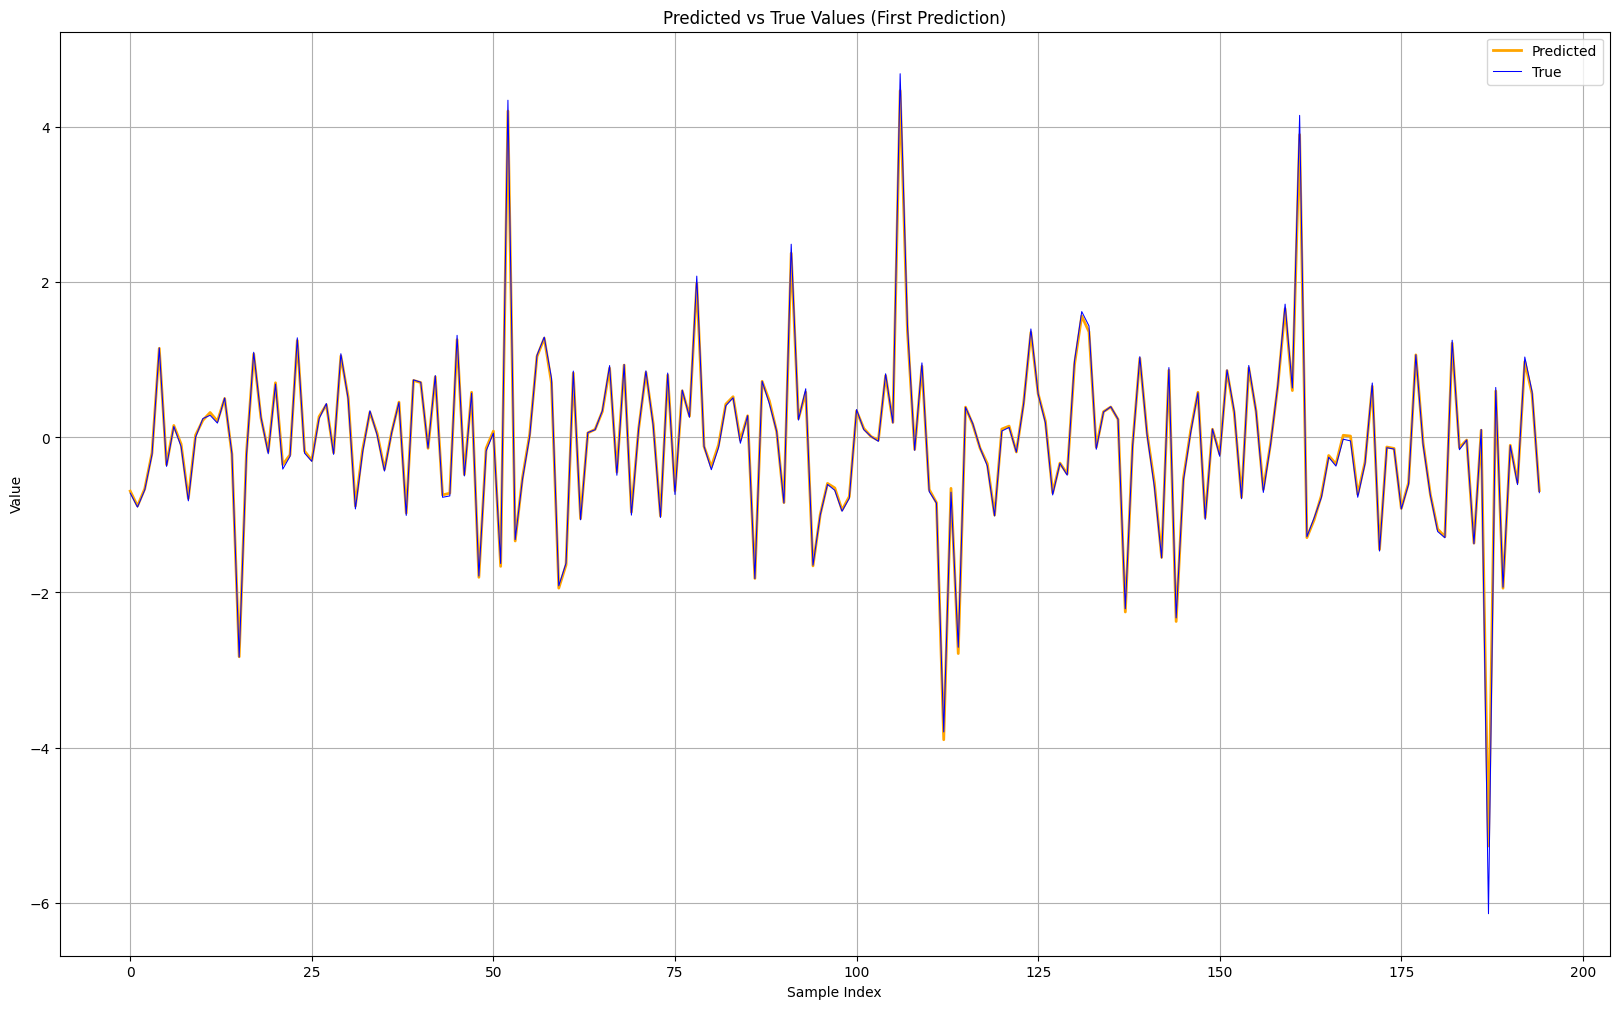

In [30]:
# Plotting
plt.figure(figsize=(20, 12))
plt.plot(pred_first, label='Predicted', color='orange', linewidth=2)
plt.plot(true_first, label='True', color='blue', linewidth=0.75)
plt.title('Predicted vs True Values (First Prediction)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

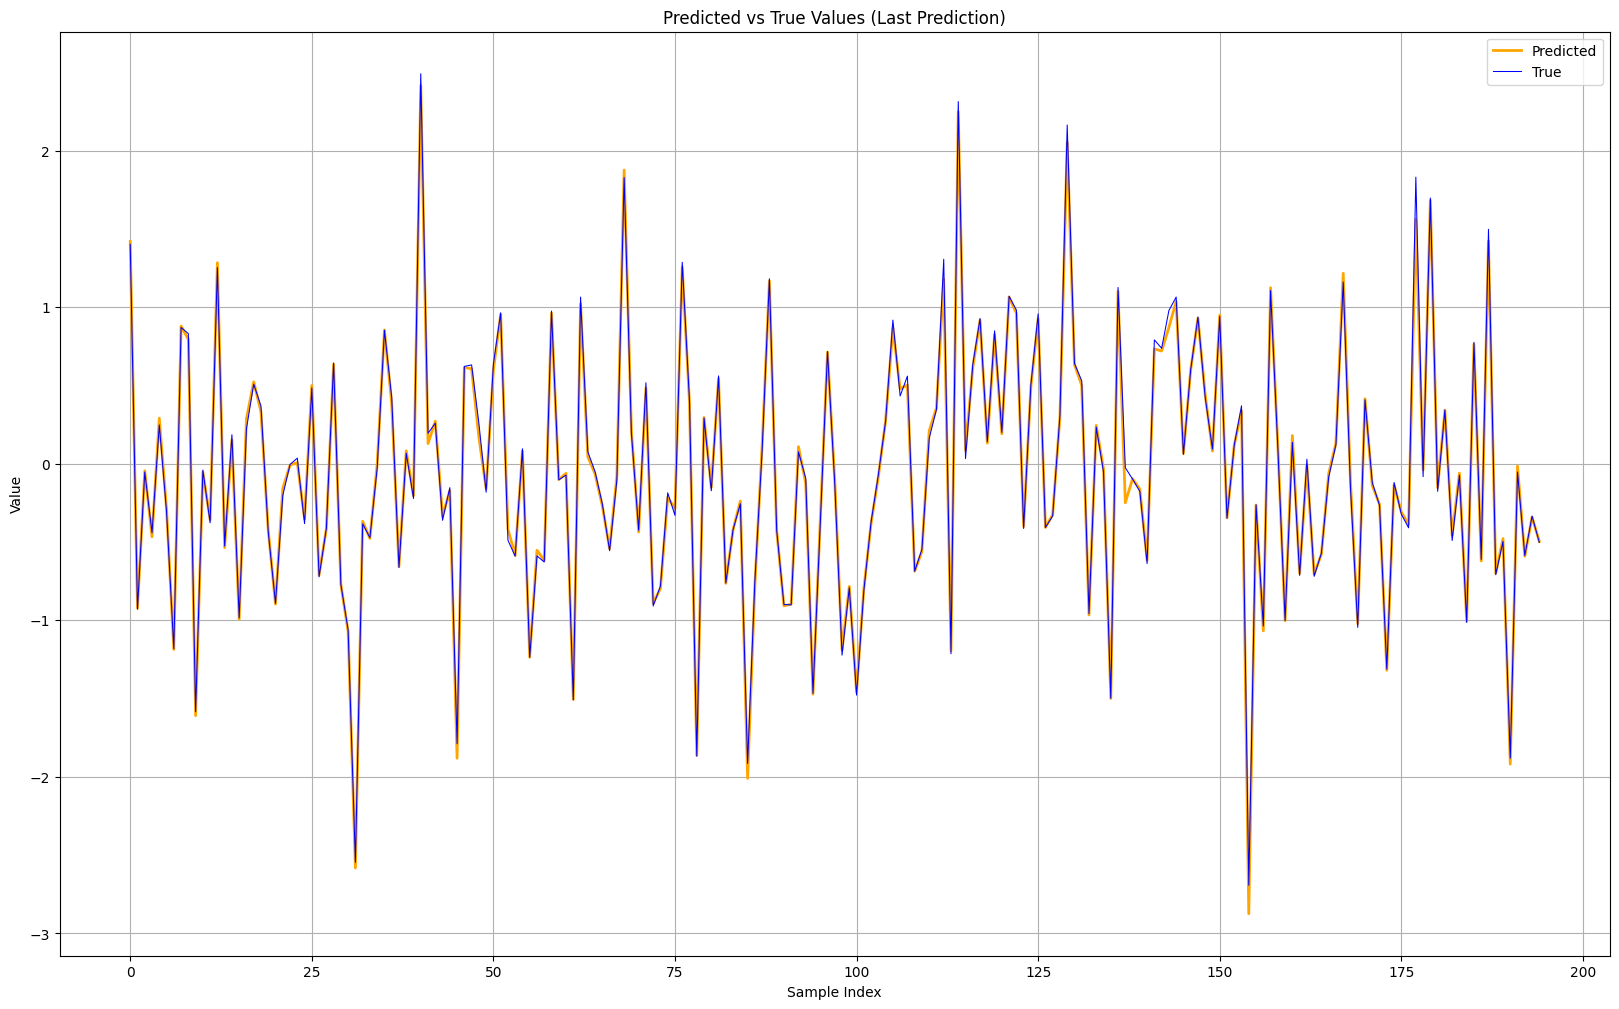

In [31]:
# Plotting
plt.figure(figsize=(20, 12))
plt.plot(pred_last, label='Predicted', color='orange', linewidth=2)
plt.plot(true_last, label='True', color='blue', linewidth=0.75)
plt.title('Predicted vs True Values (Last Prediction)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()